# Pitch Distribution Calculation for Multiple Recordings

This notebook calculates the Pitch Distribution for multiple files using single distribution exraction parameters.

## 1. Initialization 

In [1]:
# Set your token here from https://dunya.compmusic.upf.edu/user/profile/
# This is a random token
token = 'j9fh831536f7f98hp18b3d148klbc2by4k21fx7'

In [2]:
import os 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from compmusic.dunya import docserver as ds
from compmusic import dunya as dn
from external_utilities.predominantmelodymakam import PredominantMelodyMakam
from external_utilities.pitchdistribution import PitchDistribution
from external_utilities.converter import Converter

from compmusic import dunya
dn.set_token(token)

%matplotlib inline
CENTS_IN_OCTAVE=1200
KOMAS_IN_OCTAVE = 53
REF_PITCH=220             # What is this????
KOMA_CENT = CENTS_IN_OCTAVE / KOMAS_IN_OCTAVE

In [13]:
MBID = [ "1701ceba-bd5a-477e-b883-5dacac67da43",
        "48fb37f4-0db9-4bf9-8051-51640bbcf6f1",
        "26da8cac-5757-4494-a214-25ad564fc292",
        ]

In [30]:
dataDir0 = os.path.join('..', 'Oguz', 'data','recordings') # Directory of the recordings
dataDir1 = os.path.join('..', 'Oguz', 'data','pitchTracks','correct_pitchTracks') # directory of the pitch tracks

## 2) Pitch Track Extraction

In [15]:
hopSize = 441 

def compute_pitch(filename):
    
    extractor = PredominantMelodyMakam(hopSize,filter_pitch=True)
    results = extractor.run(filename)
    
    timeStep = extractor.get_settings()['hopSize'] / extractor.get_settings()['sampleRate']
              
    pitch = results['settings']  # collapse the keys in settings
    pitch['pitch'] = results['pitch']
    pitch['timeStep'] = timeStep
    
    return pitch

def truncate(x,y):
    return int(x*(10)**y) / 10**y   

In [16]:
pitchTrackDict = dict() # Dictionary for the pitch tracks in Hz
pitchSeriesDictHz = dict() # Dictionary for the pitch Series
tonicDict = dict() # Dictionary for the tonic in Hz

 The cell below **creates the pitch file or reads it**

In [18]:
for ID in MBID:
    
    mp3_filename = os.path.join(dataDir0, '{}.mp3'.format(ID))
    pitchFile = os.path.join(dataDir1, '{}.txt'.format(ID)) # change to .pitch if you are using an unedited pitch track
    
    #Reading the tonic annotation for the recording from Dunya
    content = ds.file_for_document(ID, 'audioanalysis', 'tonic')
    content = json.loads(content.decode())
    tonic_hz = content['value'] # Tonic frequency in Hertz
    tonicDict[ID] = tonic_hz
    
    pitchTrackDict[ID] = dict() 
    
    # If pitch file exists, read it, if not run the extractor and create the pitch file
    if not os.path.exists(pitchFile):
        print('Extracting Pitch Track {}'.format(ID))

        pitch = compute_pitch(mp3_filename) # Time / Pitch / Salience 
       
        pitchSeriesHz = [] # Pitch Track List
        
        with open(pitchFile, 'w') as fp:
            for p_triplet in pitch['pitch']:
                
                # p is for the recordingsData.json
                if not p_triplet[1]:
                    p = 'S'   # put an S for Silent
                else:
                    p = truncate(p_triplet[1],2)
                
                # p_triplet is for the .pitch file
                # The pitch is truncated to 2 digits after the decimal point
                fp.write(str(p_triplet[0]) + '\t' + str(truncate(p_triplet[1],2) )+'\n') 
                pitchSeriesHz.append(p_triplet[1])
                
                pitchTrackDict[ID][str(p_triplet[0])] = str(p) # Add the time key and the pitch to the dict
            
        pitchSeriesHz = np.array(pitchSeriesHz)
    
        
    else:
        print('Loading Pitch Track')
        pitchData = np.loadtxt(pitchFile)
        timeStamps = pitchData[:,0]
        pitchSeriesHz = pitchData[:,1]
        
        for p_duo in pitchData:
            
            if not p_duo[1]:
                p = 'S'
            else:
                p = truncate(p_duo[1],2)
            
            pitchTrackDict[ID][str(p_duo[0])] = str(p) # Add the time key and the pitch to the dict
                
    pitchSeriesDictHz[ID] = pitchSeriesHz # Record the pitch series array in the dictionary


Loading Pitch Track
Loading Pitch Track
Loading Pitch Track


## 3) Pitch Distribution Calculation

In [19]:
# Function definition for automatic scale-interval detection from pitch distribution
def peakLocationDetection(pcd,tresh,ws):
    '''A simple peak detection implementation for demonstration purposes
    Thresholds are manually set for this demo
    '''
    windowSize = ws  # should be odd
    midPointIndex = int(windowSize / 2)
    threshold = np.max(pcd) * tresh
    peakIndexes = []
    for index in range(len(pcd)-windowSize):
        frame = pcd[index:index+windowSize]
        if np.argmax(frame) == midPointIndex and np.max(frame) > threshold:
            peakIndexes.append(index + midPointIndex)
    return peakIndexes

In [20]:
def komaValidator(lst,bound,iterations):
    """
    This function takes a list in cents, a lower bound in cents for identifying two different 
    perdeler, and the number of iterations to be performed to return a new list in cents, that
    are seperated by at least the bound (1 Hc preferably). It keeps the larger of the two perde.    
    """
    assert bound >= 22.0, 'The lower bound must be greater than 22 cents!'
    
    new_lst = lst.copy()
    
    for a in range(iterations):
        
        delta = []

        for i in range(len(new_lst)-1):
            delta.append(new_lst[i+1]-new_lst[i])

        for j in range(len(delta)-1):
            if delta[j] < bound:                
                new_lst.remove( min(new_lst[j],new_lst[j+1])) # discard the smallest
                break # exit the inner for loop only
                
    return new_lst        

In [21]:
def shift_to_tonic(lst):
    """
    This function takes a list of a pitch space in cents and returns how much the list is shifted from the tonic,
    with the cents list centered around the tonic.
    """
    dist = 0
    nlst = lst.copy()
   
    # if 0.0 is in the list exit code        
    if not (0.0 in nlst):
        
        neg = []
        pos = []
            
        for l in nlst:           
            if l < 0:
                neg.append(l)
            elif l> 0:
                pos.append(l)
                        
        if not neg:
            
            dist = min(pos)
            nlst = [l - dist  for l in nlst]
                        
        else:
            m1 = max(neg)
            m2 = min(pos)

            if abs(m1) > m2:
                dist = m2
                nlst = [l - dist for l in nlst]
            else:
                dist = m1
                nlst = [l - dist for l in nlst]        
        
    return nlst,dist               

In [22]:
#pitch distribution extractor parameters in cents
pd_params = {'kernel_width':10, 'step_size': 2.5}

threshold = 0.05 # Threshold for peak picking
windowSize = 13 # Window Size for the peak location detection

In [23]:
pitchDistrib = {} 

cents = {} # pitchLocation() returned peaks
centsKoma = {} # koma validated 

centsTonicShift = {} # koma validated and shifted to 0.0

In [24]:
for ID in MBID:
    
    #create the pitch distribution
    pitchDistrib[ID] = PitchDistribution.from_hz_pitch(pitchSeriesDictHz[ID], tonicDict[ID], **pd_params)   
    
    # find the locations of the peaks using peakLocationDetection()
    peakLocations = list(peakLocationDetection(pitchDistrib[ID].vals,threshold,windowSize))
    
    # the peaks in cents
    cents[ID] = list(pitchDistrib[ID].bins[peakLocations])
    centsKoma[ID] = komaValidator(cents[ID],22.64,20) # koma validate the peaks
    
    # center the distribution around the calculated tonic
    shifted,distance = shift_to_tonic(centsKoma[ID])
    centsTonicShift[ID] = {'cents': shifted, 'distance': distance }

In [25]:
pitchDistrib_binsShifted = {} # all the bins are shifted 

for ID in MBID:
    pitchDistrib_binsShifted[ID] = [i-centsTonicShift[ID]['distance'] for i in pitchDistrib[ID].bins]    

## 4) Pitch Distribution Plots

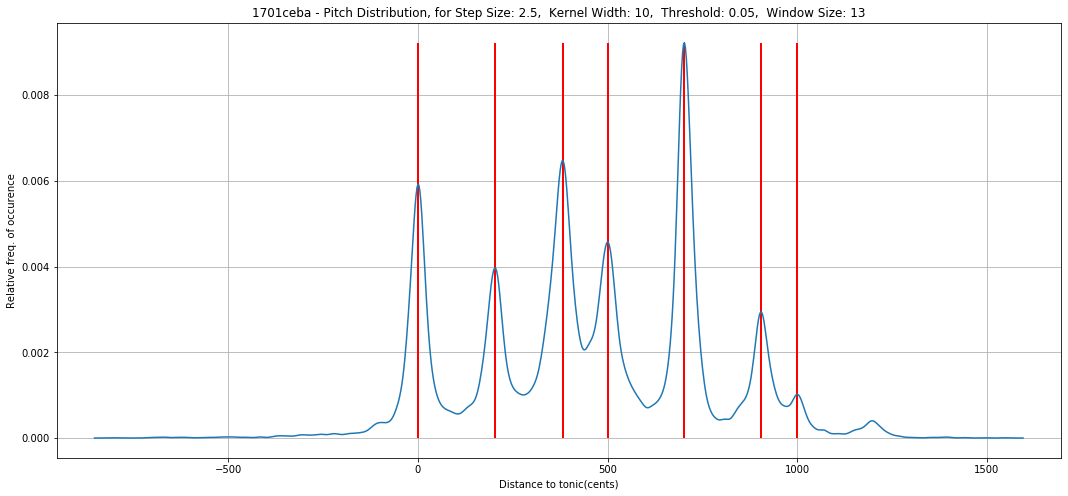

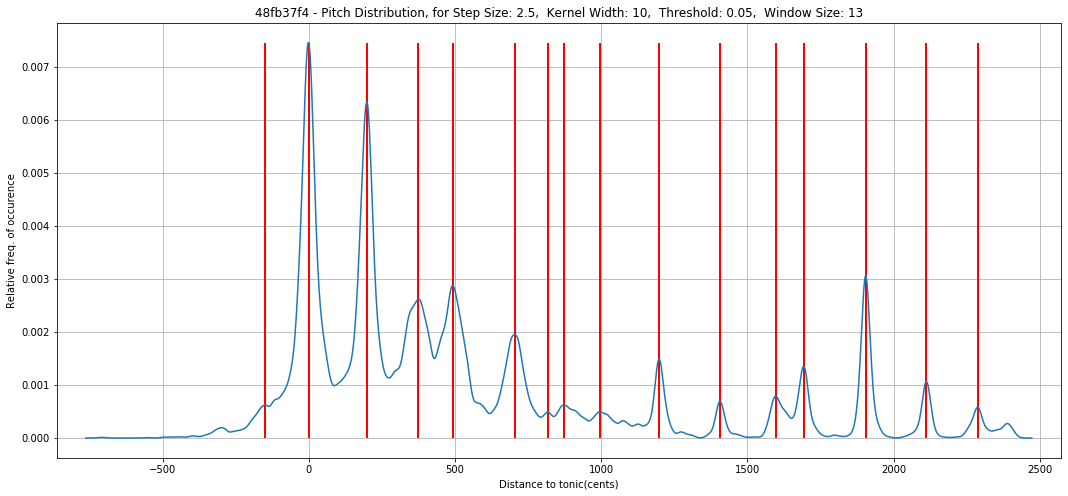

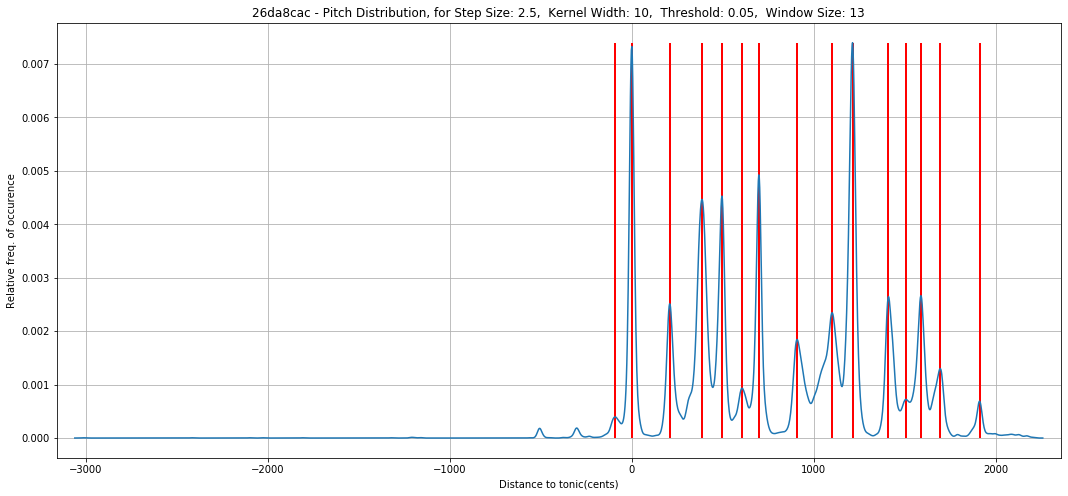

In [26]:
for ID in MBID:
    
    plt.figure(figsize=(18,8))
    
    plt.plot(pitchDistrib_binsShifted[ID],pitchDistrib[ID].vals)
    plt.vlines(centsTonicShift[ID]['cents'], 0, max(pitchDistrib[ID].vals), color='r', lw=2)
    
    lower = min(pitchDistrib_binsShifted[ID]) - 100
    higher = max(pitchDistrib_binsShifted[ID]) + 100

    plt.title('{} - Pitch Distribution, for Step Size: {},  Kernel Width: {},  Threshold: {},  Window Size: {}'\
              .format(ID.split('-')[0],pd_params['step_size'],pd_params['kernel_width'],threshold,windowSize))
        
    plt.grid()
    plt.xlim([lower, higher])
    plt.ylabel('Relative freq. of occurence')
    plt.xlabel('Distance to tonic(cents)')